In [416]:
from PIL import ImageGrab
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib as mpl
import pyperclip

### old

[(875, (255, 157, 2)), (514, (254, 203, 2)), (379, (252, 99, 3)), (45, (250, 237, 7)), (825, (243, 23, 7)), (996, (239, 247, 189)), (1428, (219, 251, 84)), (914, (254, 205, 2)), (1422, (167, 247, 159)), (574, (254, 155, 2)), (774, (5, 159, 249)), (1385, (1, 95, 253)), (678, (0, 163, 252)), (1362, (254, 250, 2)), (57, (194, 160, 86)), (42, (178, 252, 138)), (51, (0, 91, 252)), (1072, (255, 99, 0)), (46, (101, 244, 182)), (1411, (0, 255, 208)), (1349, (0, 255, 249)), (864, (15, 80, 236)), (37, (4, 242, 240)), (1425, (2, 228, 246)), (60, (0, 228, 236))]
['#DBFB54', '#02E4F6', '#A7F79F', '#00FFD0', '#015FFD', '#FEFA02', '#00FFF9', '#FF6300', '#EFF7BD', '#FECD02', '#FF9D02', '#0F50EC', '#F31707']
13


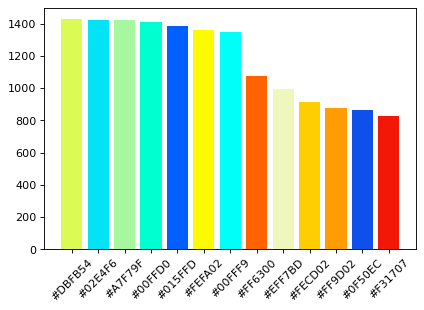

In [270]:
num_colors = 13
threshold = 1
image = ImageGrab.grabclipboard()
if image is None:
    raise IOError('检测到剪贴板没有图片')
result = image.convert('P', palette=Image.ADAPTIVE, colors=num_colors*2)
result = result.convert('RGB')
main_colors = result.getcolors()
print(main_colors)
# 排序
sort_colors = []
for _ in range(len(main_colors)):
    max_color = [0, (0, 0, 0)]
    for i in main_colors:
        if i[0] >= max_color[0]:
            max_color = i
    sort_colors.append(max_color)
    main_colors.remove(max_color)

sort_colors = sort_colors[:num_colors]
# 去除相似颜色
i = 0
while i < len(sort_colors):
    count, rgb = sort_colors[i]
    if np.cov(rgb)**0.5 <= threshold:
        sort_colors.remove(sort_colors[i])
        i -= 1
    for count, RGB in sort_colors[:i]:
        if np.cov([RGB[i]-rgb[i] for i in range(3)])**0.5 <= threshold:
            sort_colors.remove(sort_colors[i])
    i += 1

hex_colors = []
hex_counts = []
select_colors = []
for count, RGB in sort_colors:
    color = '#'
    for i in RGB:
        color += str(hex(i))[-2:].replace('x', '0').upper()
    hex_colors.append(color)
    hex_counts.append(count)
    select_colors.append(RGB)

print(hex_colors)
plt.figure(dpi=80)
plt.bar(range(len(hex_counts)), hex_counts, color=(hex_colors))  
ax = plt.gca()
ax.set_xticks(range(len(hex_colors)))
ax.set_xticklabels(hex_colors, rotation=45)
print(len(hex_colors))
image

### New

['#A602BE', '#8003BF', '#2130D3', '#0196C0', '#01B6B8', '#02D67E', '#01E501', '#A1E140', '#D0E139', '#D2A63D', '#D58135', '#DC3849', '#D9027F']
发现13种颜色已成功写入剪贴板√


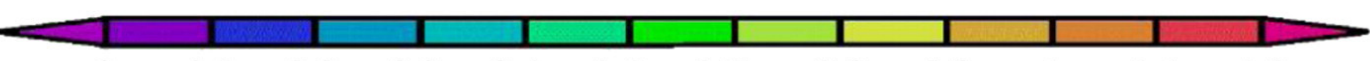

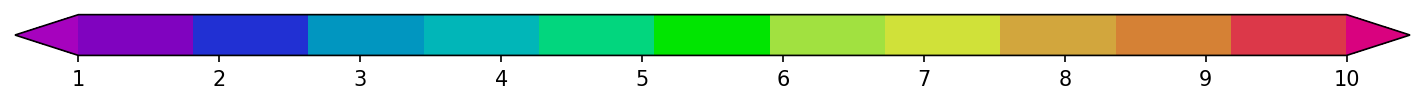

In [669]:
def get_crop_color(im):
    result = im.convert('P', palette=Image.ADAPTIVE, colors=10)
    result = result.convert('RGB')
    count_colors = result.getcolors()
    i = 0
    while True:
        if i >= len(count_colors):
            break
        count, RGB = count_colors[i]
        if np.cov(RGB)**0.5 <= 10 or np.mean(RGB) > 250 or np.mean(RGB) < 30:
            count_colors.remove(count_colors[i])
            continue
        i += 1
    if len(count_colors):
        counts = [i[0] for i in count_colors]
        colors = [i[1] for i in count_colors]
        return colors[counts.index(max(counts))]
    else:
        return []

num_colors = 13
main_colors = []
img = ImageGrab.grabclipboard()

if img is None:
    print('检测到剪贴板没有图片')
# 旋转
Width, Height = img.size
if Height > Width:
    img = img.transpose(Image.ROTATE_90)
    Width, Height = Height, Width
width = Width / num_colors
for i in range(num_colors):
#     print(i)
    left = width * i
    upper = 0
    right = left + width
    lower = Height
    crop_img = img.crop([left, upper, right, lower])
    c = get_crop_color(crop_img)
    if len(c):
        main_colors.append(c)

# remove similiar colors
threshold = 3
i = 0
while True:
    if i >= len(main_colors):
        break
    b = True
    rgb = main_colors[i]
    if  np.cov(rgb)**0.5 < threshold or np.mean(rgb) < 20:  # 去除黑色，灰色
#         print(rgb)
        main_colors.remove(rgb)
        continue
    for RGB in main_colors[:i]:
        if np.cov([RGB[i]-rgb[i] for i in range(3)])**0.5 <= threshold:  # 去除和之前过滤过的相似颜色
#             print(RGB, rgb)
            main_colors.remove(rgb)
            b = False
            break
    i += int(b)
# convert to hex colors
hex_colors = []
select_colors = []
for RGB in main_colors:
    color = '#'
    for i in RGB:
        color += str(hex(i))[-2:].replace('x', '0').upper()
    hex_colors.append(color)
    select_colors.append(RGB)
print(hex_colors)
pyperclip.copy(str(hex_colors))
print(f'发现{len(hex_colors)}种颜色已成功写入剪贴板√')
fig, ax = plt.subplots(figsize=(12, 0.36), dpi=150)
cmap = mpl.colors.ListedColormap(hex_colors[1:-1] if len(hex_colors) >= 3 else hex_colors)
cmap.set_under(hex_colors[0])
cmap.set_over(hex_colors[-1])
plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(1, 10)), 
             orientation='horizontal', extend='both', cax=ax)
img

In [581]:
def show_count_colors(count_colors):
    counts = [i[0] for i in count_colors]
    colors = [i[1] for i in count_colors]
    plt.bar(range(len(counts)), counts, color=[np.array(i)/255 for i in colors])

In [660]:
def get_crop_color(im):
    result = im.convert('P', palette=Image.ADAPTIVE, colors=12)
    result = result.convert('RGB')
    count_colors = result.getcolors()
    i = 0
    while True:
        if i >= len(count_colors):
            break
        count, RGB = count_colors[i]
        if np.cov(RGB)**0.5 <= 10 or np.mean(RGB) > 250 or np.mean(RGB) < 30:
            count_colors.remove(count_colors[i])
            continue
        i += 1
    if len(count_colors):
        counts = [i[0] for i in count_colors]
        colors = [i[1] for i in count_colors]
        return colors[counts.index(max(counts))], count_colors, result
    else:
        

i = 49
left = width * i
upper = 0
right = left + width
lower = Height
im = img.crop([left, upper, right, lower])
result = im.convert('P', palette=Image.ADAPTIVE, colors=10)
result = result.convert('RGB')
c, count_colors, i = get_crop_color(im)  # 163,1,185
show_count_colors(count_colors)
print(c, count)
result

[(1197, (255, 255, 255)), (16, (254, 253, 254)), (15, (253, 255, 255)), (53, (252, 253, 253)), (34, (245, 245, 245)), (44, (83, 79, 81)), (47, (12, 11, 12)), (79, (6, 1, 6)), (1, (255, 254, 255)), (82, (254, 254, 254)), (59, (252, 252, 252)), (47, (196, 194, 195))]


ValueError: max() arg is an empty sequence